In [1]:
#https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573
import torch
import numpy as np
import os
import sys
sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"]="4"
import torchvision
from voc import *
from coco import *
import torchvision.transforms as transforms
from torchvision.models import resnet152, resnet101, resnet18, resnet34, resnet50
from tqdm import tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
from config import seed_everything
seed_everything(0)
from models import *
from torchsummary import summary

import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import json

from pytorch_grad_cam import GradCAM
%matplotlib inline

/home/seongha/anaconda3/envs/LTML/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from backbones.config import config

In [3]:
import timm
model = timm.create_model('resnet50', pretrained=True)


In [4]:
from models import *
from backbones.config import config
import pathlib

print(config)
for k, v in config.items():
  print("{} : {}".format(k, v))
  pathlib.Path('../figures/{}'.format(k)).mkdir(parents=True, exist_ok=True) 

m_li = [base_resnet50(model_path=config['resnet50'], num_classes=80, pretrained=True),\
   base_vit(config['vit'], 80, image_size=224, pretrained=True),\
      base_swin(config['swin'], 80, image_size=224, pretrained=True),\
         base_convnext(config['convnext'], 80, image_size=224, pretrained=True), \
           base_mlpmixer(config['mlpmixer'], num_classes=80, image_size=224, pretrained=True)]
# m_li2 = [BaseResnet(m_li[0], 80)]
p_li = ['/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_cnt_in21k-4-4-0_resnet50_base_best.pth.tar', \
  '/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_cnt_in21k-4-4-0_vit_base_best.pth.tar', \
    '/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_cnt_in22k-4-4-0_swin_base_best.pth.tar',\
  '/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_cnt_in22k-4-4-0_convnext_base_best.pth.tar',\
      '/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_cnt_in21k-4-4-0_mlpmixer_base_best.pth.tar' ,\
  ]

def get_model(index):
  path = p_li[index]
  model = m_li[index]
  di = torch.load(path)
  print(di['best_score'])
  print(di.keys())
  model.load_state_dict(di['state_dict'])

  for n, p in model.named_parameters():
    if p.requires_grad==False:
      p.requires_grad=True
  return model

{'resnet50': 'resnetv2_50x3_bitm_in21k', 'vit': 'vit_base_patch16_224_in21k', 'swin': 'swin_base_patch4_window7_224_in22k', 'convnext': 'convnext_base_in22k', 'mlpmixer': 'mixer_b16_224_in21k'}
resnet50 : resnetv2_50x3_bitm_in21k
vit : vit_base_patch16_224_in21k
swin : swin_base_patch4_window7_224_in22k
convnext : convnext_base_in22k
mlpmixer : mixer_b16_224_in21k
Linear(in_features=768, out_features=80, bias=True)


/home/seongha/anaconda3/envs/LTML/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
model = get_model(0)

{'mAP': tensor(75.3806), 'OF1': 0.7281215292811023, 'CF1': 0.706165627126658}
dict_keys(['epoch', 'arch', 'state_dict', 'best_score'])


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [7]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
print(model_children)
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
    # if type(model_children[i]) == nn.Block:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                # if type(child) == nn.Block:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")

[Sequential(
  (0): Sequential(
    (conv): StdConv2d(3, 192, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (pad): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): ResNetStage(
      (blocks): Sequential(
        (0): PreActBottleneck(
          (downsample): DownsampleConv(
            (conv): StdConv2d(192, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm): Identity()
          )
          (norm1): GroupNormAct(
            32, 192, eps=1e-05, affine=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv1): StdConv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): GroupNormAct(
            32, 192, eps=1e-05, affine=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv2): StdConv2d(192, 192, kernel_size=(3,

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
                # MultiScaleCrop(224, scales=(1.0, 0.875, 0.75, 0.66, 0.5), max_distort=2),
                transforms.ToTensor(),
                normalize,
            ])

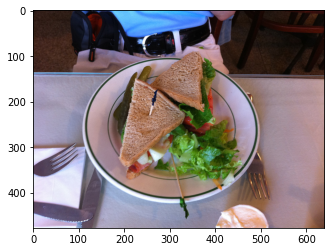

In [17]:
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2
img_li = [{"file_name": "COCO_train2014_000000475804.jpg", "labels": [57, 35, 13]},
{"file_name": "COCO_train2014_000000195525.jpg", "labels": [49, 35, 22]},
 {"file_name": "COCO_train2014_000000249764.jpg", "labels": [49, 35, 22]},

 {"file_name": "COCO_train2014_000000199956.jpg", "labels": [18, 63]},
{"file_name": "COCO_train2014_000000098760.jpg", "labels": [18, 28]},
{"file_name": "COCO_train2014_000000485894.jpg", "labels": [18, 71]},

{"file_name": "COCO_train2014_000000462472.jpg", "labels": [49, 4, 5]}, {"file_name": "COCO_train2014_000000039261.jpg", "labels": [49, 4, 5]}, {"file_name": "COCO_train2014_000000236760.jpg", "labels": [49, 4, 5]},
 {"file_name": "COCO_train2014_000000497261.jpg", "labels": [49, 4, 5]}, {"file_name": "COCO_train2014_000000072969.jpg", "labels": [49, 4, 62]},

{"file_name": "COCO_train2014_000000101418.jpg", "labels": [34]}, {"file_name": "COCO_train2014_000000445528.jpg", "labels": [34]}, {"file_name": "COCO_train2014_000000334080.jpg", "labels": [34]}, {"file_name": "COCO_train2014_000000108627.jpg", "labels": [34]}, {"file_name": "COCO_train2014_000000122108.jpg", "labels": [34]},
{"file_name": "COCO_train2014_000000479712.jpg", "labels": [10, 34, 79]},
{"file_name": "COCO_train2014_000000230559.jpg", "labels": [49, 34, 2]},
]
bad_img_id = '/home/seongha/LT-ML/data/coco/data/val2014/{}'.format("COCO_val2014_000000531092.jpg")
good_img_id = '/home/seongha/LT-ML/data/coco/data/val2014/{}'.format("COCO_val2014_000000309633.jpg")
image = np.array(Image.open(bad_img_id))
plt.imshow(image)
import copy

image = cv2.resize(image, (512, 512))
image = np.float32(image) / 255
# image = transform(image)
original_img = copy.copy(image)
image = preprocess_image(image,
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
image = image.to(device)
x = torch.clone(image)

# print(x)

In [13]:
for i, p in model.named_parameters():
  print(i, p)

features.0.conv.weight Parameter containing:
tensor([[[[-9.5166e-02, -1.6750e-01, -1.9272e-01,  ..., -2.1890e-01,
           -1.8253e-01, -1.5660e-01],
          [-8.2356e-02, -1.2970e-01, -1.6017e-01,  ..., -1.8482e-01,
           -1.6428e-01, -1.3226e-01],
          [-1.5602e-02, -4.0558e-02, -7.0238e-02,  ..., -8.6060e-02,
           -7.5183e-02, -5.5329e-02],
          ...,
          [ 3.4513e-02,  7.6120e-02,  7.0823e-02,  ...,  8.4123e-02,
            5.9876e-02,  4.5473e-02],
          [ 3.4791e-02,  1.0780e-01,  1.3035e-01,  ...,  1.6944e-01,
            1.2517e-01,  9.1030e-02],
          [ 7.3172e-02,  1.6032e-01,  2.0860e-01,  ...,  2.6395e-01,
            2.0602e-01,  1.7241e-01]],

         [[ 5.4612e-02,  7.1326e-02,  9.9515e-02,  ...,  1.1274e-01,
            7.5103e-02,  7.2673e-02],
          [ 3.2920e-02,  5.5116e-02,  7.6429e-02,  ...,  8.6443e-02,
            5.7795e-02,  6.9556e-02],
          [-4.6140e-03,  1.2173e-02,  2.4060e-02,  ...,  3.3866e-02,
            1

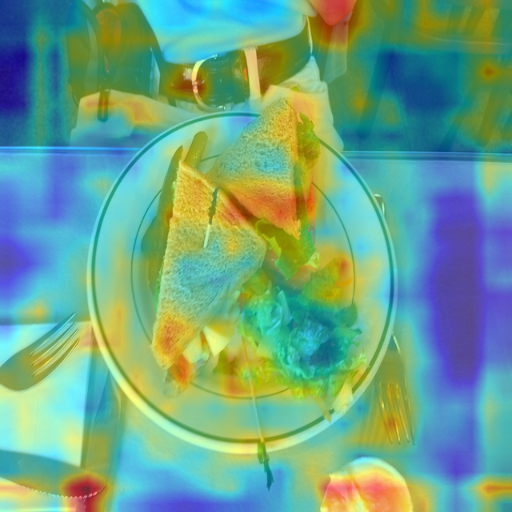

In [25]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
stages = model.features[1]
# print(stages[3].blocks[2].norm3)
target_layers = [stages[2].blocks[2].norm3]
# target_layers = [model.layer4[-1]]
input_tensor = image
 # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(2)]#[2] backpack

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(original_img, grayscale_cam, use_rgb=True)
Image.fromarray(visualization)